In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation
from tensorflow.keras.models import Model


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

%matplotlib inline
%load_ext autoreload
%autoreload 2

Num GPUs Available:  1
2.9.1


In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions

model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.ndimage import rotate
import imutils

#https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

def load_img(img_path,img_shape, preprocess=True, angle=0):
    
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    #num_channel=img_shape[2]


    img = image.load_img(img_path , target_size=(img_rows, img_cols))    
    #img = rotate(img, angle, reshape=False)
    img = imutils.rotate(np.array(img), angle=angle)
    if preprocess:
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)

        img =  preprocess_input(img)
        return img

    #data = np.array(data)
    #data = data.astype('float32')
    #data /= 255
    #labels=np.array(labels)
    #print('data shape',data.shape)
    #print('labels shape',labels.shape)
    return np.array(img)

In [4]:
def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

In [41]:
from tensorflow.image import flip_up_down, flip_left_right, rot90

def rescale_0_1(tensor):
    tensor = tf.cast(tensor, tf.float64)
    tensor = (tensor - tf.math.reduce_min(tensor)) * (1 / (tf.math.reduce_max(tensor) - tf.math.reduce_min(tensor)))
    return tensor

def rescale_0_1_channel_wise(tensor):
    num_channels = tf.shape(tensor)[-1]
    channels = tf.TensorArray(tf.float64, size=num_channels)
    for channel_idx in tf.range(num_channels):
        channel = rescale_0_1(tensor[:,:,channel_idx])
        channels = channels.write(channel_idx, channel)
    tensor = tf.transpose(channels.stack(), [1,2,0])
    return tensor

def sym_anti_sym_conv2d(image, w):  
    kernel_size=(3,3)   
    filters = tf.reshape(w, (kernel_size[0],kernel_size[1],w.shape[-1]*w.shape[-2]))
    mat_flip_x = flip_left_right(filters)
    mat_flip_y = flip_up_down(filters)

    mat_flip_xy = flip_left_right(flip_up_down(filters))

    sum = filters + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = rot90(sum)

    sym_f = (sum + mat_sum_rot_90) / 8
    anti_f = filters-sym_f


    w_sym = tf.reshape(sym_f, w.shape)
    w_anti = tf.reshape(anti_f, w.shape)

    x_s =  tf.nn.conv2d(image, filters=w_sym, strides= (1, 1),  
                        padding= 'SAME')
    x_a =  tf.nn.conv2d(image, filters=w_anti, strides=(1, 1), 
                        padding= 'SAME')

    return x_s, x_a

(64,)
(1, 224, 224, 64)


TypeError: Invalid shape (1, 224, 224) for image data

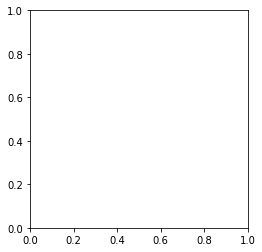

In [14]:

layer = model.layers[1]
filters, biases = layer.get_weights()
print(biases.shape)
img_in = load_img('test_images/piano_zoom.png', angle=45, img_shape=(224,224), preprocess=True)

x =  tf.nn.relu(tf.nn.conv2d(img_in, filters=filters, strides=(1, 1), padding= 'SAME')+biases)
a,b  = sym_anti_sym_conv2d(img_in, filters)
print(a.shape)
plt.imshow(np.mean(x[0]-a, axis=-1))



MovieWriter imagemagick unavailable; using Pillow instead.


(224, 224, 64)
tf.Tensor(-248.13022, shape=(), dtype=float32)
tf.Tensor(45, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-248.13022, shape=(), dtype=float32)
tf.Tensor(45, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-205.70898, shape=(), dtype=float32)
tf.Tensor(45, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-231.4731, shape=(), dtype=float32)
tf.Tensor(10, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-209.68752, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-231.36273, shape=(), dtype=float32)
tf.Tensor(51, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-231.56676, shape=(), dtype=float32)
tf.Tensor(62, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-263.8645, shape=(), dtype=float32)
tf.Tensor(47, shape=(), dtype=int64)
(224, 224, 64)
tf.Tensor(-248.65422, shape=(), dtype=float32)
tf.Tensor(47, shape=(), dtype=int64)


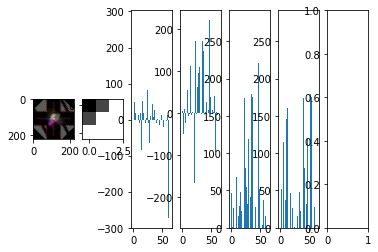

In [62]:

from tkinter import Y
from matplotlib.animation import FuncAnimation

import time
fig, ax = plt.subplots(1,7)
fig.set_tight_layout(False)

i=2
def update(i):
    label = 'timestep {0}'.format(i)

    img  = load_img('test_images/piano_zoom.png', angle=i*45, img_shape=(224,224),preprocess=False)
    img_in = load_img('test_images/piano_zoom.png', angle=i*45, img_shape=(224,224), preprocess=True)

    ax[0].imshow(img)
    ax[1].imshow(img_in[0, 111:114, 111:114, 1], cmap='gray')
    ax[2].clear()
    ax[3].clear()
    ax[4].clear()
    ax[5].clear()

    r_s, r_a = sym_anti_sym_conv2d(img_in, filters)
    r = tf.nn.conv2d(img_in, filters=filters, strides=(1, 1), padding= 'SAME')

    print(r_s[0].shape)
    ax[2].bar( np.arange(0, 64), r_s[0][112, 112, :])
    ax[3].bar( np.arange(0, 64), r_a[0][112, 112, :])
    #ax[4].bar( np.arange(0, 64), tf.nn.relu(r + biases)[0, 112, 112, :])
    shift_val = tf.math.argmax(r_a[0][112, 112, :])
    print(tf.math.reduce_min(r_a[0][112, 112, :]))
    print(shift_val)
    ax[4].bar( np.arange(0, 64), (tf.nn.relu(r_a[0] + r_s[0] +  biases )[112, 112, :]))
    ax[5].bar( np.arange(0, 64), tf.roll(get_cnn_out(img_in, 1)[112, 112,:] , -shift_val, axis=0))

    return ax



anim = FuncAnimation(fig, update, frames=np.arange(0, 8), interval=400)

anim.save('video_out/testMov.gif', dpi=80, writer='imagemagick')

In [ ]:
np.arange(0, 64)

In [ ]:
get_cnn_out(img_in, 2)[124, 124,:]

In [ ]:
m = np.array([[-21, -23,  -18],
              [-19, 0, -61.5], 
              [-25, -21, 62.5]])


In [ ]:
-np.transpose(m)